In [1]:
import importlib
import mc_config #Import classes to creat configurations
import cnn_pt # Import the CNN model
import torch
import torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time
import multiprocessing
import torch.optim.adamw 


In [2]:
num_cores=multiprocessing.cpu_count()
print("Number of cores available:", num_cores)
T=np.linspace(0.1, 5, 100) # Define the range of temperature values
Beta=1/T[::-1] # Define the range of beta values
params=mc_config.Params(L=32,beta=Beta,J=1,H=0,N_sample=100)
#print("Temperature values:", T)
#print("Beta values:", Beta)

Number of cores available: 10


In [14]:
# create configurations
configurations=mc_config.IsingModelDataset(params)
configurations.get_configs()
dataset=configurations.configs

In [15]:
print(dataset.shape)

(1, 100, 32, 32)


In [8]:
np.save('dataset_32_100.npy', dataset) # Save the dataset to a file

In [3]:
loaded_dataset = np.load('dataset_32_100.npy')  # Load the dataset from the file
print("Dataset loaded with shape:",loaded_dataset.shape)

Dataset loaded with shape: (100, 100, 32, 32)


In [4]:
beta_to_index = {beta: i for i, beta in enumerate(Beta)}  # Map beta values to indices
index_to_beta = {i: beta for i, beta in enumerate(Beta)}  # Map indices back to beta values

# prepare the dataset for DataLoader
def data_preparation(dataset,Beta):
    X=torch.tensor(dataset.reshape(-1, params.L, params.L), dtype=torch.float).unsqueeze(1)
    Y=torch.tensor(np.arange(len(Beta)), dtype=torch.long).repeat_interleave(params.N_sample)
    return TensorDataset(X, Y)

# create DataLoader
batch_size=10000
data = data_preparation(loaded_dataset,Beta)
dataloader = DataLoader(data,batch_size=batch_size, shuffle=False, num_workers=num_cores)


In [52]:
def train_test(model,dataloader,num_epochs,learning_rate):
    #writer = SummaryWriter()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,betas=(0.9,0.95),eps=1e-8)
    model.train()
    Losses=[]
    Accuracies=[]
   
    data_iter = iter(dataloader)
    fixed_batch = next(data_iter)  # Extract the first batch
    inputs, labels = fixed_batch

    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0
        N_correct=0
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        epoch_loss = loss.item()
        N_correct = (predicted == labels).sum().item()
        

        avg_loss = epoch_loss
        accuracy = N_correct / len(labels)
        Losses.append(avg_loss)
        Accuracies.append(accuracy)
        
        # Log to TensorBoard
       # writer.add_scalar('Loss/train', avg_loss, epoch)
       # writer.add_scalar('Accuracy/train', accuracy, epoch)

        Losses.append(avg_loss)
        Accuracies.append(accuracy)
        
        end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}, accuracy: {accuracy:.4f}, Time: {end_time - start_time:.2f}s') #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}, accuracy: {N_correct/total_samples:.4f}, Time: {end_time - start_time:.2f}s')
    #writer.close()

    return Losses, Accuracies

In [53]:
model = cnn_pt.CnnPT(input_size=params.L, num_classes=len(Beta), out_channels=5, kernel_size=3, stride=8)
Losses, Accuracies = train_test(model, dataloader, num_epochs=100, learning_rate=0.0005)

Epoch 1/100, Loss: 4.633735179901123, accuracy: 0.0000, Time: 0.00s
Epoch 2/100, Loss: 4.592897891998291, accuracy: 0.0000, Time: 0.00s
Epoch 3/100, Loss: 4.552084445953369, accuracy: 0.0000, Time: 0.00s
Epoch 4/100, Loss: 4.511296272277832, accuracy: 0.0000, Time: 0.00s
Epoch 5/100, Loss: 4.470523834228516, accuracy: 0.0000, Time: 0.00s
Epoch 6/100, Loss: 4.429743766784668, accuracy: 0.0000, Time: 0.00s
Epoch 7/100, Loss: 4.388908863067627, accuracy: 0.0000, Time: 0.00s
Epoch 8/100, Loss: 4.347953796386719, accuracy: 0.0000, Time: 0.00s
Epoch 9/100, Loss: 4.306811332702637, accuracy: 0.0000, Time: 0.00s
Epoch 10/100, Loss: 4.2654314041137695, accuracy: 0.0000, Time: 0.00s
Epoch 11/100, Loss: 4.22378396987915, accuracy: 0.0000, Time: 0.00s
Epoch 12/100, Loss: 4.181848049163818, accuracy: 0.0000, Time: 0.00s
Epoch 13/100, Loss: 4.139607906341553, accuracy: 0.0100, Time: 0.00s
Epoch 14/100, Loss: 4.097047328948975, accuracy: 0.0300, Time: 0.00s
Epoch 15/100, Loss: 4.054146766662598, accu

In [5]:
# training loop 
#from torch.utils.tensorboard import SummaryWriter
def train_model(model,dataloader,num_epochs,learning_rate):
    #writer = SummaryWriter()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.9,0.95),eps=1e-8)
    model.train()
    Losses=[]
    Accuracies=[]
    total_samples = len(dataloader.dataset)
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0
        N_correct=0
        
        for batch in dataloader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, dim=1)
            epoch_loss += loss.item()
            N_correct += (predicted == labels).sum().item()
        

        avg_loss = epoch_loss / len(dataloader)
        accuracy = N_correct / total_samples
        Losses.append(avg_loss)
        Accuracies.append(accuracy)
        
        # Log to TensorBoard
       # writer.add_scalar('Loss/train', avg_loss, epoch)
       # writer.add_scalar('Accuracy/train', accuracy, epoch)

        Losses.append(avg_loss)
        Accuracies.append(accuracy)
        
        end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}, accuracy: {N_correct/total_samples:.4f}, Time: {end_time - start_time:.2f}s') #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}, accuracy: {N_correct/total_samples:.4f}, Time: {end_time - start_time:.2f}s')
    #writer.close()

    return Losses, Accuracies


In [6]:
model = cnn_pt.CnnPT(input_size=params.L, num_classes=len(Beta), out_channels=5, kernel_size=3, stride=8)


In [10]:
Losses, Accuracies = train_model(model, dataloader, num_epochs=5000, learning_rate=0.0008)

Epoch 1/5000, Loss: 2.8711018562316895, accuracy: 0.1998, Time: 1.51s
Epoch 2/5000, Loss: 2.8724071979522705, accuracy: 0.2012, Time: 1.52s
Epoch 3/5000, Loss: 2.8711180686950684, accuracy: 0.2010, Time: 1.49s
Epoch 4/5000, Loss: 2.871105432510376, accuracy: 0.1996, Time: 1.44s
Epoch 5/5000, Loss: 2.8710291385650635, accuracy: 0.2001, Time: 1.44s
Epoch 6/5000, Loss: 2.8706979751586914, accuracy: 0.2002, Time: 1.44s
Epoch 7/5000, Loss: 2.8705761432647705, accuracy: 0.2005, Time: 1.43s
Epoch 8/5000, Loss: 2.870405912399292, accuracy: 0.2012, Time: 1.45s
Epoch 9/5000, Loss: 2.870201826095581, accuracy: 0.2012, Time: 1.44s
Epoch 10/5000, Loss: 2.8700194358825684, accuracy: 0.2010, Time: 1.45s
Epoch 11/5000, Loss: 2.8697915077209473, accuracy: 0.2004, Time: 1.47s
Epoch 12/5000, Loss: 2.8694968223571777, accuracy: 0.1996, Time: 1.53s
Epoch 13/5000, Loss: 2.869274139404297, accuracy: 0.1995, Time: 1.55s
Epoch 14/5000, Loss: 2.869126558303833, accuracy: 0.2000, Time: 1.48s
Epoch 15/5000, Loss:

In [15]:
torch.save(model.state_dict(),'weights_32_100.pth')

In [ ]:
model_loaded = cnn_pt.CnnPT(input_size=params.L, num_classes=len(Beta), out_channels=5, kernel_size=3, stride=8)
model_loaded.load_state_dict(torch.load('weights_32_100.pth'))

<All keys matched successfully>

In [17]:
Losses, Accuracies = train_model(model_loaded, dataloader, num_epochs=10, learning_rate=0.0001)

Epoch 1/10, Loss: 2.9094135761260986, accuracy: 0.1994, Time: 1.61s
Epoch 2/10, Loss: 2.9094245433807373, accuracy: 0.1994, Time: 1.53s
Epoch 3/10, Loss: 2.9093682765960693, accuracy: 0.1995, Time: 1.45s
Epoch 4/10, Loss: 2.9093568325042725, accuracy: 0.1996, Time: 1.47s
Epoch 5/10, Loss: 2.9093401432037354, accuracy: 0.1997, Time: 1.47s
Epoch 6/10, Loss: 2.9093120098114014, accuracy: 0.1996, Time: 1.44s
Epoch 7/10, Loss: 2.9092845916748047, accuracy: 0.1997, Time: 1.46s
Epoch 8/10, Loss: 2.9092659950256348, accuracy: 0.2000, Time: 1.48s
Epoch 9/10, Loss: 2.9092466831207275, accuracy: 0.1998, Time: 1.49s
Epoch 10/10, Loss: 2.909222364425659, accuracy: 0.1996, Time: 1.49s


In [35]:
# Detecting the phase transition
weights=model.fc.weight.data.numpy()  
rows, cols = weights.shape
print("Weights shape:", weights.shape)
def detect_phase_transition(weights, Beta):
    rows, cols = weights.shape
    plt.figure(figsize=(12, 8)) 
    cax = plt.imshow(np.transpose(weights[20:80:3,:]), cmap='hot', aspect='auto')
    plt.colorbar(cax)

    plt.xlabel("Temperature Labels")
    x_positions = np.arange(0, len(Beta[20:80:3]))  # Every 3rd index: [0, 3, 6, ..., 27]
    x_labels = [f"{beta:.2f}" for beta in Beta[20:80:3]]  # Every 3rd Beta value, formatted
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=10)

    plt.ylabel("Hidden Neurons")
    y_ticks = np.arange(0, cols,cols // 10)  # Adjust the step size for y-ticks
    plt.yticks(y_ticks)

    plt.title("Heatmap of Weights from the Fully Connected Layer")
    plt.tight_layout()
    plt.show()




Weights shape: (100, 80)


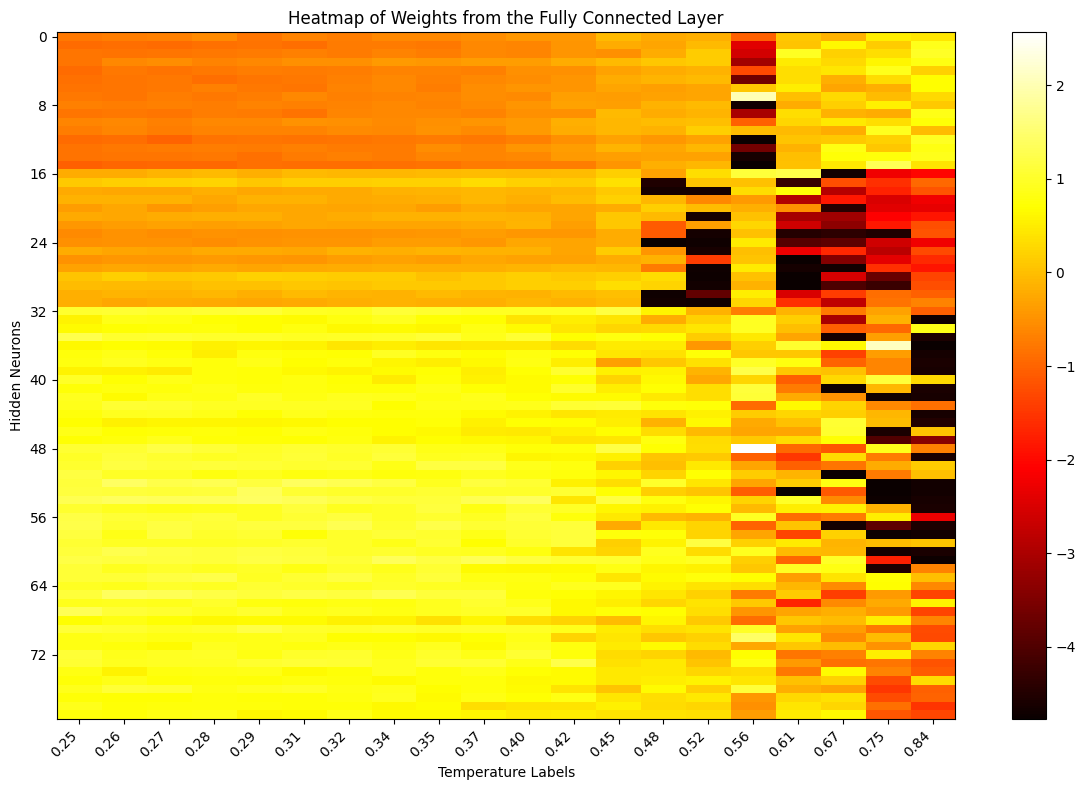

In [36]:
detect_phase_transition(weights, Beta)

In [63]:
def accumated_weights(weights,Beta):
    plt.figure(figsize=(12, 8))
    plt.title("Accumulated Weights vs Beta")
    plt.plot(Beta, np.sum(weights, axis=1), marker='o')

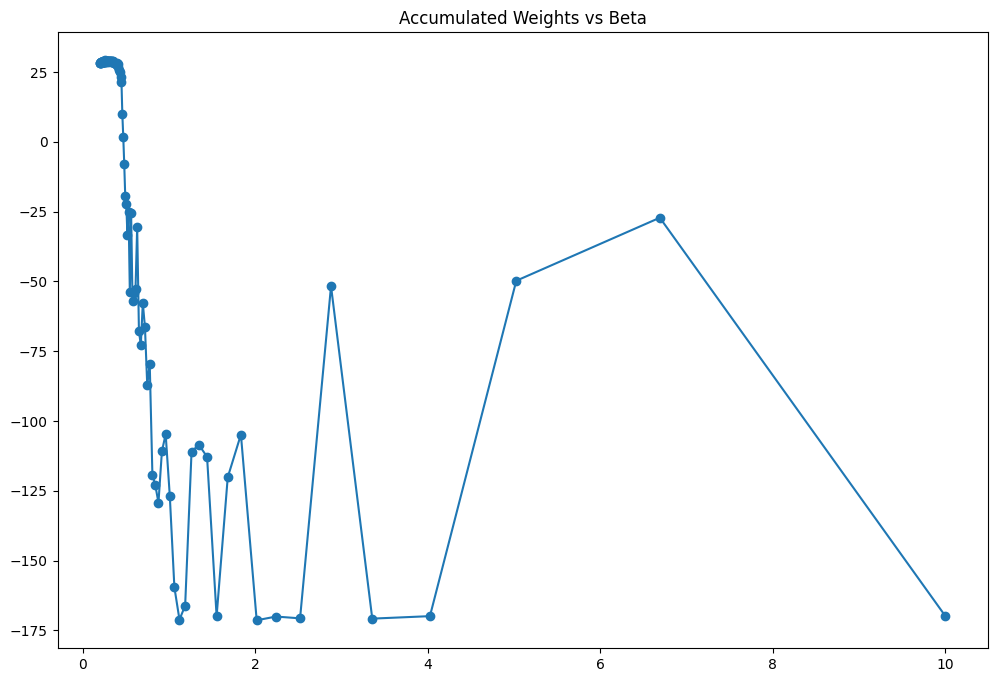

In [64]:
accumated_weights(weights,Beta)